In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import shap
import matplotlib.pyplot as plt
import folium
import matplotlib
import json
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# Windows 上常見的中文字型
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# 讓負號正常顯示（可選）
matplotlib.rcParams['axes.unicode_minus'] = False

/Users/yefangyu/Desktop/dm_final/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LOAD DATA！！

DT best params: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 1}
DT CV accuracy: 0.7666666666666666
RF CV accuracy: 0.9166666666666666


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

ET CV accuracy: 0.9333333333333332


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

GeoJSON properties keys: ['名稱', '行政區域代碼', '比例尺分母']


ValueError: key_on `'properties.TOWNNAME'` not found in GeoJSON.

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

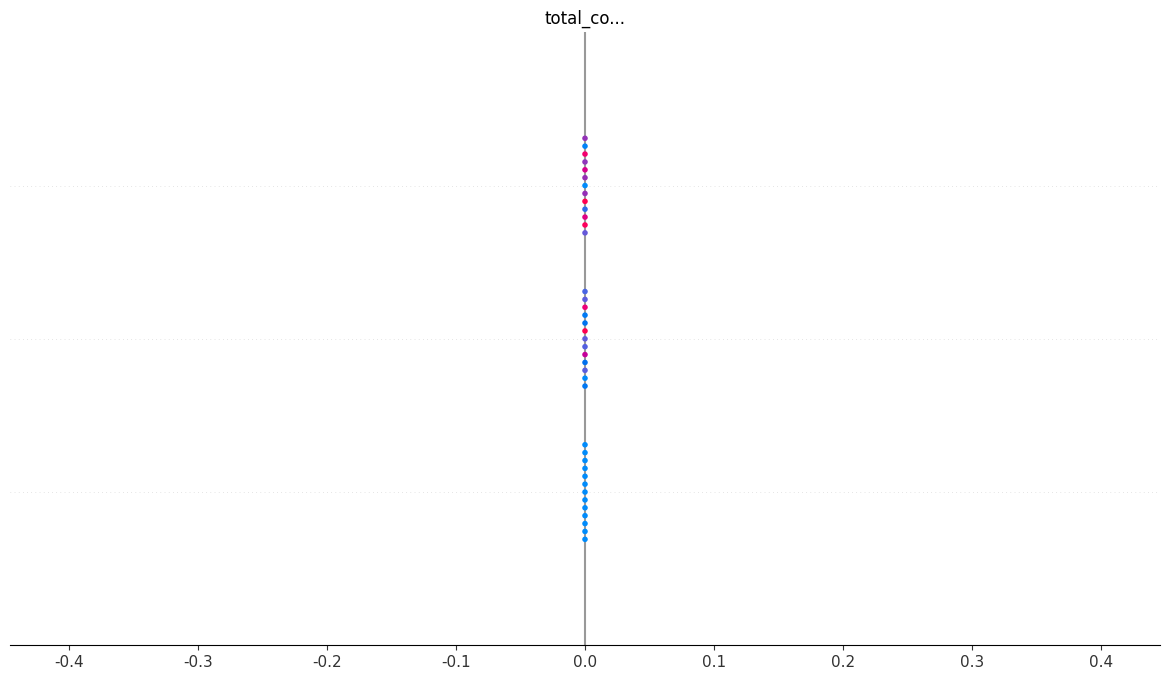

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
/Users/yefangyu/Desktop/dm_final/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because no

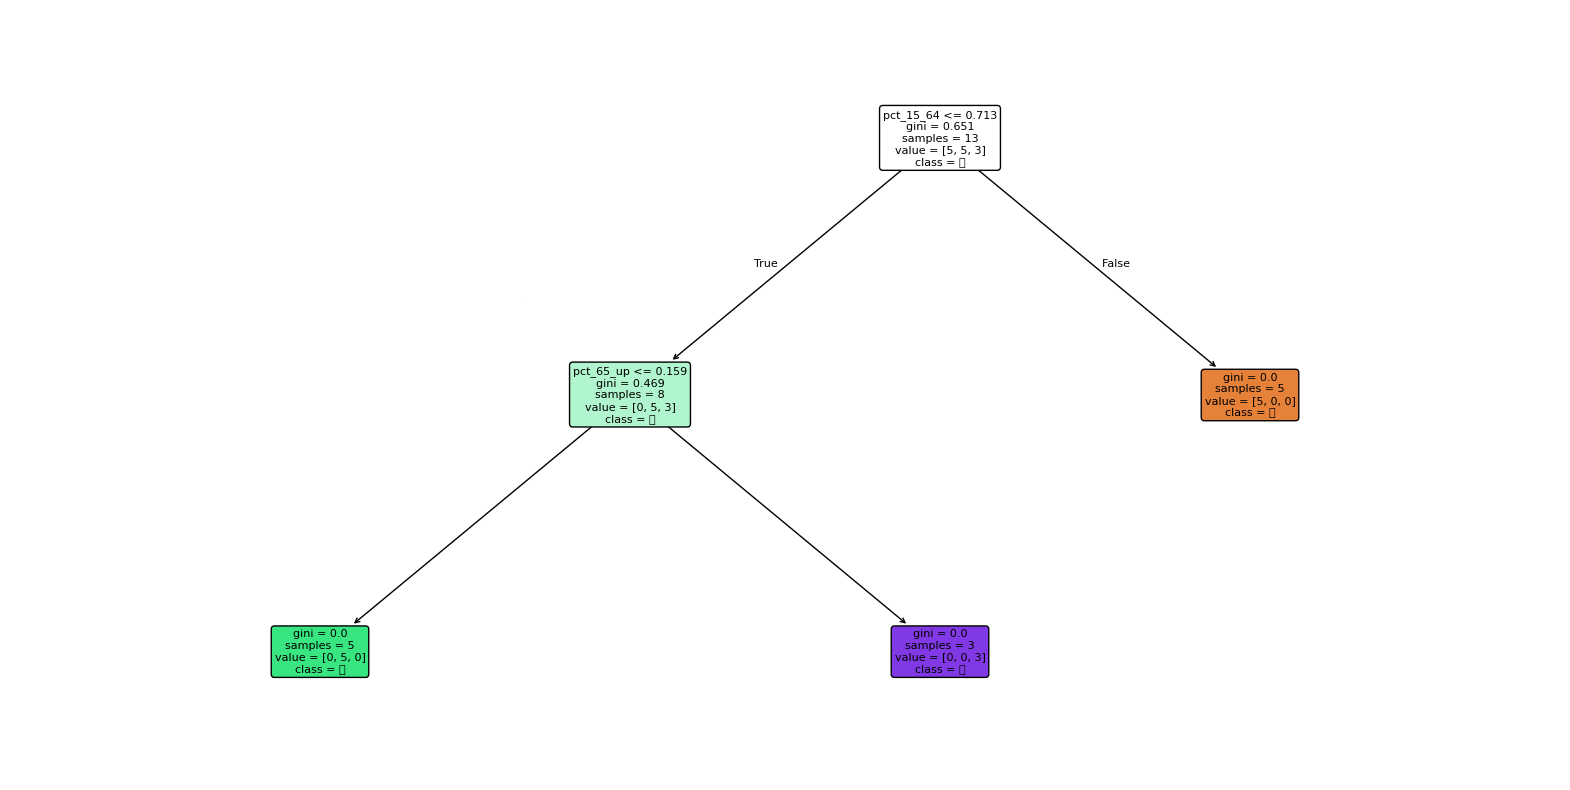

In [4]:
def load_and_process_data():
    # 1) 各區15+人口 by 性別/年齡
    df_ageedu = pd.read_excel(
        'data/12桃園市各區十五歲以上現住人口數按性別、年齡及教育程度(分).ods',
        engine='odf', header=1
    )
    df_ageedu = df_ageedu[
        df_ageedu['區域別'].notna() &
        (df_ageedu['區域別'] != '總　計') &
        (df_ageedu['性別'] == '計')
    ][['區域別','年齡別','總計']].rename(columns={'總計':'population'})
    age_map = {
        '15～19歲':'15-64','20～24歲':'15-64','25～29歲':'15-64','30～34歲':'15-64',
        '35～39歲':'15-64','40～44歲':'15-64','45～49歲':'15-64','50～54歲':'15-64',
        '55～59歲':'15-64','60～64歲':'15-64','65歲以上':'65+'
    }
    df_ageedu = df_ageedu[df_ageedu['年齡別'].isin(age_map)].copy()
    df_ageedu['age_group'] = df_ageedu['年齡別'].map(age_map)
    age_summary = (
        df_ageedu
        .groupby(['區域別','age_group'])['population']
        .sum().unstack(fill_value=0).reset_index()
    )

    # 2) 1月現住戶口（MultiIndex header → 壓平）
    df_jan = pd.read_excel(
        'data/112年12月份現住人口及原住民人口數.ods',
        engine='odf', header=[2,3]
    )
    df_jan.columns = [
        f"{l1}_{l2}" if pd.notna(l2) else str(l1)
        for l1, l2 in df_jan.columns
    ]
    region_col = [c for c in df_jan.columns if '區域別' in c or '行政區' in c][0]
    pop_col    = [c for c in df_jan.columns if '區域人口數' in c or '現住人口數' in c][0]
    df_jan = df_jan[[region_col, pop_col]].rename(
        columns={region_col:'區域別', pop_col:'total_population'}
    )
    age_summary = age_summary.merge(
        df_jan[['區域別','total_population']], on='區域別', how='left'
    )
    age_summary['pct_15_64'] = age_summary['15-64'] / age_summary['total_population']
    age_summary['pct_65_up'] = age_summary['65+'] / age_summary['total_population']

    # 3) 商業家數 & 多樣性（寬表）
    df_com = pd.read_csv(
        'data/112年12月底商業行業別及行政區域家數.csv',
        encoding='big5'
    )
    region_col    = '行政區別行業別'
    drop_cols     = ['項目','各行政區合計家數及資本額']
    industry_cols = [c for c in df_com.columns if c not in [region_col] + drop_cols]

    # 3a) 轉為純數值
    df_com[industry_cols] = (
        df_com[industry_cols]
        .apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',',''), errors='coerce'))
        .fillna(0)
    )
    # 3b) 總家數
    df_com['total_commercial'] = df_com[industry_cols].sum(axis=1)
    # 3c) Shannon 多樣性
    def shannon(row):
        vals = row[industry_cols].astype(float).values
        s = vals.sum()
        if s <= 0:
            return 0.0
        p = vals / s
        p = p[p > 0]
        return -np.sum(p * np.log(p))
    df_com['shannon_diversity'] = df_com.apply(shannon, axis=1)
    df_com = df_com[[region_col,'total_commercial','shannon_diversity']].rename(
        columns={region_col:'區域別'}
    )

    # 4) 可支配所得（移除逗號 → float）
    df_inc = pd.read_csv(
        'data/桃園市所得收入者平均每人所得來源.csv',
        encoding='utf-8-sig'
    ).rename(columns={'年別':'year','可支配所得':'per_capita_income'})
    df_inc['per_capita_income'] = (
        df_inc['per_capita_income']
        .astype(str).str.replace(',','', regex=False)
        .astype(float)
    )
    latest_year = df_inc['year'].max()
    percap = df_inc.loc[df_inc['year']==latest_year,'per_capita_income'].iloc[0]

    # 最終合併
    df = age_summary.merge(df_com, on='區域別', how='left')
    df['per_capita_income'] = percap

    return df

def generate_labels(df_feat):
    """用 KMeans 自動分三群，並依標準化後總得分映射到 低/中/高"""
    features = ['pct_15_64','pct_65_up','total_commercial',
                'shannon_diversity','per_capita_income']
    X = df_feat[features].fillna(0)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    km = KMeans(n_clusters=3, random_state=42).fit(Xs)
    df_feat['cluster'] = km.labels_
    # 以標準化後特徵和排序決定 label
    df_feat['score'] = Xs.sum(axis=1)
    order = df_feat.groupby('cluster')['score'].mean().sort_values().index
    mapping = {order[0]:'低', order[1]:'中', order[2]:'高'}
    df_feat['development_label'] = df_feat['cluster'].map(mapping)
    return df_feat

def train_and_evaluate(df_feat):
    features = ['pct_15_64','pct_65_up','total_commercial',
                'shannon_diversity','per_capita_income']
    X = df_feat[features]
    y = df_feat['development_label']

    # 清理 NaN / infinity
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 動態決定 cv
    class_counts = y.value_counts()
    min_count = class_counts.min()
    cv = min(5, int(min_count)) if min_count >= 2 else 2
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # 1) Decision Tree + GridSearchCV
    dt = DecisionTreeClassifier(random_state=42)
    param_grid = {
        'max_depth':      [3,5,7,None],
        'min_samples_leaf':[1,2,4],
        'ccp_alpha':      [0.0,0.005,0.01]
    }
    gs = GridSearchCV(dt, param_grid, cv=skf, n_jobs=-1)
    gs.fit(X, y)
    best_dt = gs.best_estimator_
    print("DT best params:", gs.best_params_)
    print("DT CV accuracy:", gs.best_score_)

    # 2) Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_scores = cross_val_score(rf, X, y, cv=skf)
    rf.fit(X, y)
    print("RF CV accuracy:", rf_scores.mean())

    # 3) Extra Trees
    et = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    et_scores = cross_val_score(et, X, y, cv=skf)
    et.fit(X, y)
    print("ET CV accuracy:", et_scores.mean())

    return best_dt, rf, et, X

def explain_and_export(dt, rf, X_test):
    # SHAP summary (RF)
    expl = shap.TreeExplainer(rf)
    sv = expl.shap_values(X_test)
    shap.summary_plot(sv, X_test, show=False)
    plt.savefig('shap_summary.png', bbox_inches='tight')

    # 決策樹圖
    plt.figure(figsize=(20,10))
    plot_tree(dt, feature_names=X_test.columns, class_names=dt.classes_,
              filled=True, rounded=True, fontsize=8)
    plt.savefig('decision_tree.png', bbox_inches='tight')

def build_map(df_feat):
    geojson_path = 'data/taoyuan_districts.geojson'

    #（選做：印出第一筆 properties 以確認要用哪個欄位）
    with open(geojson_path, encoding='utf-8') as f:
        props = json.load(f)['features'][0]['properties']
    print("GeoJSON properties keys:", list(props.keys()))
    # 通常會看到 'TOWNNAME'，對應到你的 df_feat['區域別'] 如「桃園區」

    m = folium.Map(location=[24.96, 121.22], zoom_start=10)
    folium.Choropleth(
        geo_data=geojson_path,
        data=df_feat,
        columns=['區域別','pct_15_64'],
        key_on='feature.properties.TOWNNAME',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='15–64歲人口比例'
    ).add_to(m)
    m.save('taoyuan_age_pct_map.html')
    print("互動地圖已輸出：taoyuan_age_pct_map.html")

def main():
    df = load_and_process_data()
    df = generate_labels(df)
    dt, rf, et, X = train_and_evaluate(df)
    explain_and_export(dt, rf, X)
    build_map(df)
    print("所有步驟完成：已輸出 shap_summary.png、decision_tree.png、taoyuan_age_pct_map.html")

if __name__ == '__main__':
    main()

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np

def train_svm(df_feat):
    features = ['pct_15_64', 'pct_65_up', 'total_commercial',
                'shannon_diversity', 'per_capita_income']
    X = df_feat[features]
    y = df_feat['development_label']

    # 清理 NaN / infinity
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 根據最少類別的數量決定交叉驗證次數
    class_counts = y.value_counts()
    min_count = class_counts.min()
    cv = min(5, int(min_count)) if min_count >= 2 else 2
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # 建立 SVM 模型
    svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

    # 交叉驗證準確率
    scores = cross_val_score(svm, X, y, cv=skf)
    print("SVM 交叉驗證準確率:", scores.mean())

    # 用交叉驗證預測結果產生分類報告
    y_pred_cv = cross_val_predict(svm, X, y, cv=skf)
    print("交叉驗證分類報告:\n", classification_report(y, y_pred_cv, zero_division=0))

    # 最後用全部資料訓練一個完整模型供未來使用
    svm.fit(X, y)

    return svm


# 使用 SVM 訓練模型
df = load_and_process_data()
df = generate_labels(df)
svm_model = train_svm(df)

SVM CV accuracy: 0.5333333333333333
Classification Report:
               precision    recall  f1-score   support

           中       0.00      0.00      0.00         3
           低       0.54      1.00      0.70         7
           高       0.00      0.00      0.00         3

    accuracy                           0.54        13
   macro avg       0.18      0.33      0.23        13
weighted avg       0.29      0.54      0.38        13



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
